## Data Preparation and Feature Engineering

In [31]:
import os
import json
import pandas as pd
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import numpy as np
import math
from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Load the pre-trained Sentence-BERT model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')  # Efficient for short text

# --- Helper Functions ---
def clean_text_for_quotes(text):
    """
    Cleans and normalizes quotation marks in the text.
    - Converts curly quotes to straight quotes.
    - Removes unmatched or excessive quotes.
    """
    text = text.replace("“", '"').replace("”", '"')
    text = text.replace("‘", "'").replace("’", "'")
    text = text.replace(' "', ' ').replace('" ', ' ').strip('"')
    return text

def refined_single_newline_split(text):
    """
    Splits text into paragraphs using single newline breaks to ensure proper separation.
    """
    paragraphs = [para.strip() for para in text.split("\n") if para.strip()]
    return paragraphs

def extract_paragraph_features(paragraph):
    """
    Extracts basic features for a single paragraph.
    """
    # Tokenize paragraph into sentences
    sentences = [sent for sent in sent_tokenize(paragraph) if is_valid_text(sent)]  # Filter valid sentences
    if not sentences:
        return {
        # 'sentence_length': sentence_length,
        'avg_word_length': 0,
        'unique_word_ratio': 0,
        'punctuation_density': 0,
        'capitalization_ratio': 0,
    }
    words = paragraph.split()
    unique_words = set(words)

    # Basic linguistic features
    sentence_length = np.mean([len(sentence.split()) for sentence in sentences]) if sentences else 0
    avg_word_length = np.mean([len(word) for word in words]) if words else 0
    unique_word_ratio = len(unique_words) / len(words) if words else 0

    # Punctuation and capitalization
    punctuation_density = sum(1 for char in paragraph if char in '.,!?') / len(paragraph) if len(paragraph) > 0 else 0
    capitalization_ratio = sum(1 for char in paragraph if char.isupper()) / len(paragraph) if len(paragraph) > 0 else 0

    return {
        # 'sentence_length': sentence_length,
        'avg_word_length': avg_word_length,
        'unique_word_ratio': unique_word_ratio,
        'punctuation_density': punctuation_density,
        'capitalization_ratio': capitalization_ratio,
    }

def extract_advanced_features_with_embeddings(paragraph, embedding_model):
    """
    Enhanced feature extraction for advanced metrics, including semantic shift.
    """
    # Tokenize paragraph into sentences
    sentences = [sent for sent in sent_tokenize(paragraph) if is_valid_text(sent)]  # Filter valid sentences
    if not sentences:
        return {
            'max_cosine_sim': 0,
            'rare_word_ratio': 0,
            'entropy': 0,
            'semantic_shift': 0,
            'embedding': embedding_model.encode(paragraph) if paragraph.strip() else np.zeros(embedding_model.get_sentence_embedding_dimension()),
        }

    # Tokenize paragraph into words
    words = paragraph.split()
    unique_words = set(words)

    # Compute embedding for the entire paragraph
    embedding = embedding_model.encode(paragraph)

    # Cosine similarity (bag-of-words)
    try:
        tfidf_vectorizer = TfidfVectorizer()
        tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)
        max_cosine_sim = 0
        for i in range(len(sentences) - 1):
            sim = cosine_similarity(tfidf_matrix[i], tfidf_matrix[i + 1])
            max_cosine_sim = max(max_cosine_sim, sim[0][0])
    except ValueError as e:
        if 'empty vocabulary' in str(e):
            print(f"Skipping TF-IDF computation: {e}")
            max_cosine_sim = 0

    # Rare word ratio
    rare_word_threshold = 0.01
    word_counts = Counter(words)
    rare_words = [word for word, count in word_counts.items() if count / len(words) < rare_word_threshold]
    rare_word_ratio = len(rare_words) / len(words) if words else 0

    # Entropy
    word_probs = [count / len(words) for count in word_counts.values()]
    entropy = -sum(p * math.log(p) for p in word_probs) if word_probs else 0

    # Semantic shift across sentences
    try:
        sentence_embeddings = embedding_model.encode(sentences) if sentences else [embedding]
        semantic_shift = (
            np.mean(
                [
                    cosine_similarity([sentence_embeddings[i]], [sentence_embeddings[i + 1]])[0][0]
                    for i in range(len(sentence_embeddings) - 1)
                ]
            )
            if len(sentence_embeddings) > 1
            else 0
        )
    except Exception as e:
        print(f"Error computing semantic shift: {e}")
        semantic_shift = 0

    return {
        'max_cosine_sim': max_cosine_sim,
        'rare_word_ratio': rare_word_ratio,
        'entropy': entropy,
        'semantic_shift': semantic_shift,
        'embedding': embedding,
    }


def compare_full_paragraphs(para1_features, para2_features):
    """
    Computes differences between features of two paragraphs, including embedding similarity.
    """
    feature_differences = {
        f'diff_{feature}': abs(para1_features[feature] - para2_features[feature])
        for feature in para1_features.keys() if feature != 'embedding'
    }

    # Compute embedding similarity
    embedding_similarity = cosine_similarity(
        [para1_features['embedding']], [para2_features['embedding']]
    )[0][0]
    feature_differences['embedding_similarity'] = embedding_similarity

    return feature_differences

def process_paragraph_with_embeddings(text, labels):
    """
    Processes text and labels into paragraph-level feature comparisons, including embedding similarity.
    """
    paragraphs = refined_single_newline_split(text)
    data = []
    for i in range(len(paragraphs) - 1):
        para1 = paragraphs[i]
        para2 = paragraphs[i + 1]
        label = labels[i]
        
        # Extract features for both paragraphs
        para1_features = {**extract_paragraph_features(para1), **extract_advanced_features_with_embeddings(para1)}
        para2_features = {**extract_paragraph_features(para2), **extract_advanced_features_with_embeddings(para2)}

        # Compute feature differences and embedding similarity
        comparison_features = compare_full_paragraphs(para1_features, para2_features)
        comparison_features['label'] = label
        comparison_features['paragraph_1'] = para1
        comparison_features['paragraph_2'] = para2
        data.append(comparison_features)
    
    return pd.DataFrame(data)

# --- Usage Example ---
# Assuming `problem_33_text` and `problem_33_labels` are loaded
# processed_data_with_embeddings = process_paragraph_with_embeddings(problem_33_text, problem_33_labels)

# Save the processed dataset to CSV
# processed_data_with_embeddings.to_csv("processed_problem_33_with_embeddings.csv", index=False)
# print("Processed data saved to 'processed_problem_33_with_embeddings.csv'.")


In [32]:
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch

def prepare_data_for_bilstm_from_directory(text_dir, label_dir):
    """
    Prepares input data for BiLSTM from all files in specified directories.
    :param text_dir: Directory containing text files.
    :param label_dir: Directory containing label JSON files.
    :return: Padded feature and label tensors.
    """
    all_features = []
    all_labels = []

    # Pair text and label files
    text_files = sorted([f for f in os.listdir(text_dir) if f.endswith(".txt")])
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith(".json")])

    if len(text_files) != len(label_files):
        raise ValueError("Mismatch between number of text files and label files!")

    documents = [(os.path.join(text_dir, t), os.path.join(label_dir, l)) for t, l in zip(text_files, label_files)]
    all_data = []

    for text_path, label_path in documents:
        # Load text and labels
        with open(text_path, 'r') as tf:
            text = tf.read()
        with open(label_path, 'r') as lf:
            labels = json.load(lf)["changes"]

        if len(refined_single_newline_split(text)) - 1 == len(labels):

            # Process paragraphs and extract features
            processed_data = process_paragraph_with_embeddings(text, labels)
            all_data.append(processed_data)
            
            # Extract features and labels
            features = processed_data.drop(columns=['label', 'paragraph_1', 'paragraph_2']).to_numpy()
            labels = processed_data['label'].to_numpy()

            all_features.append(features)
            all_labels.append(labels)

    # Pad features and labels
    padded_features = pad_sequences(all_features, dtype='float32', padding='post', value=0.0)
    padded_labels = pad_sequences(all_labels, dtype='int32', padding='post', value=-1)

    # Convert to tensors (PyTorch example)
    feature_tensor = torch.tensor(padded_features, dtype=torch.float32)
    label_tensor = torch.tensor(padded_labels, dtype=torch.int64)

    consolidated_data = pd.concat(all_data, ignore_index=True)

    return feature_tensor, label_tensor, consolidated_data

In [39]:
import os
import json
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import numpy as np
import pandas as pd
import math

# Load Spacy's pretrained English model with 'ner'
nlp = spacy.load("en_core_web_sm")

# Initialize NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Initialize Sentiment Intensity Analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

def is_valid_text(text):
    """
    Check if the text is valid (not empty and contains meaningful words).
    """
    stop_words = set(stopwords.words('english'))
    tokens = set(word_tokenize(text.lower()))
    meaningful_words = tokens - stop_words
    return bool(text.strip()) and bool(meaningful_words)

# Additional Helper Functions
def extract_named_entities(paragraph):
    """
    Extract named entities from a paragraph using Spacy's NER.
    """
    doc = nlp(paragraph)
    named_entities = {ent.text for ent in doc.ents}
    return named_entities

def compute_jaccard_similarity(para1, para2):
    """
    Compute the Jaccard similarity between unique words in two paragraphs.
    """
    words1, words2 = set(para1.split()), set(para2.split())
    intersection = words1.intersection(words2)
    union = words1.union(words2)
    return len(intersection) / len(union) if union else 0

def compute_tfidf_cosine_similarity(para1, para2):
    """
    Compute TF-IDF cosine similarity between two paragraphs with error handling.
    """
    para1 = preprocess_text(para1)
    para2 = preprocess_text(para2)

    if not is_valid_text(para1) or not is_valid_text(para2):
        print("One or both paragraphs are invalid for TF-IDF computation.")
        return 0  # Default similarity score for invalid input

    try:
        vectorizer = TfidfVectorizer(stop_words='english')
        tfidf_matrix = vectorizer.fit_transform([para1, para2])
        return cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
    except ValueError as e:
        if 'empty vocabulary' in str(e):
            print(f"Skipping TF-IDF computation: {e}")
            return 0  # Default similarity for empty vocabulary

def compute_stopword_density(paragraph):
    """
    Compute the density of stopwords in a paragraph.
    """
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(paragraph)
    stopword_count = sum(1 for word in words if word.lower() in stop_words)
    return stopword_count / len(words) if words else 0

def compute_sentiment_polarity(paragraph):
    """
    Compute the sentiment polarity score of a paragraph using VADER.
    """
    return sentiment_analyzer.polarity_scores(paragraph)['compound']

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalnum()]  # Remove punctuation and non-alphanumeric tokens
    return ' '.join(tokens)

def extract_advanced_features_with_embeddings(paragraph, embedding_model):
    """
    Enhanced feature extraction for advanced metrics, including semantic shift.
    """
    # Tokenize paragraph into sentences
    sentences = [sent for sent in sent_tokenize(paragraph) if is_valid_text(sent)]  # Filter valid sentences
    if not sentences:
        return {
            'max_cosine_sim': 0,
            'rare_word_ratio': 0,
            'entropy': 0,
            'semantic_shift': 0,
            'embedding': embedding_model.encode(paragraph) if paragraph.strip() else np.zeros(embedding_model.get_sentence_embedding_dimension()),
        }

    # Tokenize paragraph into words
    words = paragraph.split()
    unique_words = set(words)

    # Compute embedding for the entire paragraph
    embedding = embedding_model.encode(paragraph)

    # Cosine similarity (bag-of-words)
    try:
        tfidf_vectorizer = TfidfVectorizer(stop_words='english')
        tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)
        max_cosine_sim = 0
        for i in range(len(sentences) - 1):
            sim = cosine_similarity(tfidf_matrix[i], tfidf_matrix[i + 1])
            max_cosine_sim = max(max_cosine_sim, sim[0][0])
    except ValueError as e:
        if 'empty vocabulary' in str(e):
            print(f"Skipping TF-IDF computation: {e}")
            max_cosine_sim = 0

    # Rare word ratio
    rare_word_threshold = 0.01
    word_counts = Counter(words)
    rare_words = [word for word, count in word_counts.items() if count / len(words) < rare_word_threshold]
    rare_word_ratio = len(rare_words) / len(words) if words else 0

    # Entropy
    word_probs = [count / len(words) for count in word_counts.values()]
    entropy = -sum(p * math.log(p) for p in word_probs) if word_probs else 0

    # Semantic shift across sentences
    try:
        sentence_embeddings = embedding_model.encode(sentences) if sentences else [embedding]
        semantic_shift = (
            np.mean(
                [
                    cosine_similarity([sentence_embeddings[i]], [sentence_embeddings[i + 1]])[0][0]
                    for i in range(len(sentence_embeddings) - 1)
                ]
            )
            if len(sentence_embeddings) > 1
            else 0
        )
    except Exception as e:
        print(f"Error computing semantic shift: {e}")
        semantic_shift = 0

    return {
        'max_cosine_sim': max_cosine_sim,
        'rare_word_ratio': rare_word_ratio,
        'entropy': entropy,
        'semantic_shift': semantic_shift,
        'embedding': embedding,
    }

def process_paragraph_with_embeddings_advanced(text, labels):
    """
    Processes text and labels into paragraph-level feature comparisons, including advanced metrics.
    """
    paragraphs = refined_single_newline_split(text)
    paragraphs = [preprocess_text(p) for p in paragraphs if is_valid_text(p)]  # Preprocess and validate
    if not paragraphs:
        raise ValueError("No valid paragraphs after preprocessing.")

    data = []
    for i in range(len(paragraphs) - 1):
        para1 = paragraphs[i]
        para2 = paragraphs[i + 1]
        label = labels[i]

        # Extract features for both paragraphs
        para1_features = {
            **extract_advanced_features_with_embeddings(para1, embedding_model),
        }
        para2_features = {
            **extract_advanced_features_with_embeddings(para2, embedding_model),
        }

        # Compute feature differences
        comparison_features = compare_full_paragraphs_enhanced(para1_features, para2_features, para1, para2)
        comparison_features['label'] = label
        comparison_features['paragraph_1'] = para1
        comparison_features['paragraph_2'] = para2
        data.append(comparison_features)

    return pd.DataFrame(data)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/reolingovender/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/reolingovender/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/reolingovender/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [40]:
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch

def prepare_data_for_bilstm_from_directory(text_dir, label_dir):
    """
    Prepares input data for BiLSTM from all files in specified directories.
    :param text_dir: Directory containing text files.
    :param label_dir: Directory containing label JSON files.
    :return: Padded feature and label tensors.
    """
    all_features = []
    all_labels = []

    # Pair text and label files
    text_files = sorted([f for f in os.listdir(text_dir) if f.endswith(".txt")])
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith(".json")])

    if len(text_files) != len(label_files):
        raise ValueError("Mismatch between number of text files and label files!")

    documents = [(os.path.join(text_dir, t), os.path.join(label_dir, l)) for t, l in zip(text_files, label_files)]
    all_data = []

    for text_path, label_path in documents:
        # Load text and labels
        with open(text_path, 'r') as tf:
            text = tf.read()
        with open(label_path, 'r') as lf:
            labels = json.load(lf)["changes"]

        if len(refined_single_newline_split(text)) - 1 == len(labels):

            # Process paragraphs and extract features
            processed_data = process_paragraph_with_embeddings_advanced(text, labels)
            all_data.append(processed_data)
            
            # Extract features and labels
            features = processed_data.drop(columns=['label', 'paragraph_1', 'paragraph_2']).to_numpy()
            labels = processed_data['label'].to_numpy()

            all_features.append(features)
            all_labels.append(labels)

    # Pad features and labels
    padded_features = pad_sequences(all_features, dtype='float32', padding='post', value=0.0)
    padded_labels = pad_sequences(all_labels, dtype='int32', padding='post', value=-1)

    # Convert to tensors (PyTorch example)
    feature_tensor = torch.tensor(padded_features, dtype=torch.float32)
    label_tensor = torch.tensor(padded_labels, dtype=torch.int64)

    consolidated_data = pd.concat(all_data, ignore_index=True)

    return feature_tensor, label_tensor, consolidated_data

## Creating Features

In [125]:
data_set_number = 3

In [126]:
# Training
text_dir_train = f"/Users/reolingovender/Downloads/release/pan23-multi-author-analysis-dataset{data_set_number}/pan23-multi-author-analysis-dataset{data_set_number}-train/"
label_dir_train = f"/Users/reolingovender/Downloads/release/pan23-multi-author-analysis-dataset{data_set_number}/pan23-multi-author-analysis-dataset{data_set_number}-train/"

X_train, y_train, df_features_train = prepare_data_for_bilstm_from_directory(text_dir_train, label_dir_train)
print("Feature tensor shape:", X_train.shape)
print("Label tensor shape:", X_train.shape)

Feature tensor shape: torch.Size([4198, 20, 9])
Label tensor shape: torch.Size([4198, 20, 9])


In [127]:
# Save the tensor
torch.save(X_train, f"X_train_tensor_{data_set_number}.pt")
torch.save(y_train, f"y_train_tensor_{data_set_number}.pt")
df_features_train.to_excel(f'df_features_train_{data_set_number}.xlsx')

In [128]:
# Validation
text_dir_validation = f"/Users/reolingovender/Downloads/release/pan23-multi-author-analysis-dataset{data_set_number}/pan23-multi-author-analysis-dataset{data_set_number}-validation/"
label_dir_validation = f"/Users/reolingovender/Downloads/release/pan23-multi-author-analysis-dataset{data_set_number}/pan23-multi-author-analysis-dataset{data_set_number}-validation/"

X_validation, y_validation, df_features_validation = prepare_data_for_bilstm_from_directory(text_dir_validation, label_dir_validation)
print("Feature tensor shape:", X_validation.shape)
print("Label tensor shape:", y_validation.shape)

One or both paragraphs are invalid for TF-IDF computation.
Feature tensor shape: torch.Size([900, 22, 9])
Label tensor shape: torch.Size([900, 22])


In [129]:
# Save the tensor
torch.save(X_validation, f"X_validation_tensor_{data_set_number}.pt")
torch.save(y_validation, f"y_validation_tensor_{data_set_number}.pt")
df_features_validation.to_excel(f'df_features_validation_{data_set_number}.xlsx')

In [ ]:
# Load the tensor
# loaded_tensor = torch.load(f"X_validation_tensor_{data_set_number}.pt")

/var/folders/4p/fm0xjwjs36q50hz65y724w840000gn/T/ipykernel_38305/3952783358.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_tensor = torch.load(f"X_validation_ten

In [130]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim

class ParagraphDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.size(0)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create dataset and data loader
train_dataset = ParagraphDataset(X_train, y_train)
val_dataset = ParagraphDataset(X_validation, y_validation)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

## Basic BiLSTM

In [131]:
import torch
import torch.nn as nn

class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.2):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiply by 2 for bidirectional
        self.softmax = nn.LogSoftmax(dim=-1)  # For classification

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out)
        return self.softmax(output)


In [132]:
# Model parameters
input_dim = X_train.shape[2]
hidden_dim = 128
output_dim = 2

# Initialize model, loss function, and optimizer
model = BiLSTM(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    # Training phase
    for batch_features, batch_labels in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_features)
        outputs = outputs.view(-1, output_dim)
        batch_labels = batch_labels.view(-1)

        # Compute loss
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss / len(train_loader):.4f}")

/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/10, Training Loss: 0.6776
Epoch 2/10, Training Loss: 0.6545
Epoch 3/10, Training Loss: 0.6492
Epoch 4/10, Training Loss: 0.6481
Epoch 5/10, Training Loss: 0.6474
Epoch 6/10, Training Loss: 0.6459
Epoch 7/10, Training Loss: 0.6450
Epoch 8/10, Training Loss: 0.6442
Epoch 9/10, Training Loss: 0.6430
Epoch 10/10, Training Loss: 0.6422


In [133]:
# Validation phase
model.eval()
total, correct = 0, 0
with torch.no_grad():
    for batch_features, batch_labels in val_loader:
        outputs = model(batch_features)
        predictions = torch.argmax(outputs, dim=-1)

        mask = batch_labels != -1
        total += mask.sum().item()
        correct += (predictions[mask] == batch_labels[mask]).sum().item()

val_accuracy = correct / total if total > 0 else 0
print(f"Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 10/10, Validation Accuracy: 0.6196


In [134]:
# Initialize validation loss and counters
val_loss = 0.0  # Add this line to initialize val_loss
correct = 0
total = 0

# Initialize containers for storing predictions and labels
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch_features, batch_labels in val_loader:
        # Forward pass
        outputs = model(batch_features)  # Shape: (batch_size, seq_len, num_classes)

        # Pool the outputs for sequence classification (use the first token)
        pooled_outputs = outputs[:, 0, :]  # Shape: (batch_size, num_classes)

        # Use only the first token's label for sequence-level classification
        batch_labels = batch_labels[:, 0]  # Shape: (batch_size)

        # Ensure batch_labels are integers representing class indices
        batch_labels = batch_labels.long()  # Convert to integer type if needed

        # Compute loss
        loss = criterion(pooled_outputs, batch_labels)
        val_loss += loss.item()  # Accumulate the loss

        # Compute predictions
        predictions = torch.argmax(pooled_outputs, dim=1)  # Shape: (batch_size)
        correct += (predictions == batch_labels).sum().item()
        total += batch_labels.size(0)

        # Collect predictions and labels for additional metrics
        all_predictions.extend(predictions.cpu().numpy())
        all_true_labels.extend(batch_labels.cpu().numpy())

# Calculate metrics
val_accuracy = correct / total if total > 0 else 0
precision = precision_score(all_true_labels, all_predictions, average='macro')
recall = recall_score(all_true_labels, all_predictions, average='macro')
f1 = f1_score(all_true_labels, all_predictions, average='macro')

# Print validation results
print(f"Validation Loss: {val_loss / len(val_loader):.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


Validation Loss: 0.6439
Validation Accuracy: 0.6367
Precision: 0.6355, Recall: 0.6070, F1-Score: 0.5998


## BiLSTM With Attention

In [135]:
import torch
import torch.nn as nn

class BiLSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.2):
        super(BiLSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout
        )
        self.attention = nn.Linear(hidden_dim * 2, 1)  # Compute attention scores
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Final classification layer
        self.softmax = nn.LogSoftmax(dim=-1)  # Log-SoftMax for output probabilities

    def forward(self, x):
        # Pass input through BiLSTM
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_len, hidden_dim * 2)
        
        # Compute attention scores
        attention_scores = self.attention(lstm_out)  # (batch_size, seq_len, 1)
        
        # Normalize attention scores to get weights
        attention_weights = torch.softmax(attention_scores, dim=1)  # (batch_size, seq_len, 1)
        
        # Compute context vector as weighted sum of LSTM outputs
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)  # (batch_size, hidden_dim * 2)
        
        # Pass context vector through classification layer
        output = self.fc(context_vector)  # (batch_size, output_dim)
        
        return self.softmax(output)

In [136]:
# Model hyperparameters
input_dim = X_train.shape[2]  # Number of features
hidden_dim = 64  # Hidden size of LSTM
output_dim = 2   # Number of classes (binary classification)

# Initialize the model
model = BiLSTMWithAttention(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss(ignore_index=-1)  # Handle padding labels
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation
epochs = 10
for epoch in range(epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0

    # Training phase
    for batch_features, batch_labels in train_loader:
        batch_labels = batch_labels[:, 0]  # Use only the first label for sequence classification

        # Forward pass
        outputs = model(batch_features)  # Shape: (batch_size, num_classes)

        # Compute loss
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {epoch_loss / len(train_loader):.4f}")


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/10, Training Loss: 0.6815
Epoch 2/10, Training Loss: 0.6806
Epoch 3/10, Training Loss: 0.6802
Epoch 4/10, Training Loss: 0.6804
Epoch 5/10, Training Loss: 0.6794
Epoch 6/10, Training Loss: 0.6754
Epoch 7/10, Training Loss: 0.6598
Epoch 8/10, Training Loss: 0.6463
Epoch 9/10, Training Loss: 0.6392
Epoch 10/10, Training Loss: 0.6367


In [137]:
# Validation phase
model.eval()  # Set model to evaluation mode
total, correct = 0, 0
val_loss = 0

with torch.no_grad():
    for batch_features, batch_labels in val_loader:
        batch_labels = batch_labels[:, 0]  # Use only the first label for sequence classification

        # Forward pass
        outputs = model(batch_features)

        # Compute loss
        loss = criterion(outputs, batch_labels)
        val_loss += loss.item()

        # Compute accuracy
        predictions = torch.argmax(outputs, dim=1)  # Get predicted class indices
        correct += (predictions == batch_labels).sum().item()
        total += batch_labels.size(0)

val_accuracy = correct / total if total > 0 else 0
print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 10/10, Validation Loss: 0.6369, Validation Accuracy: 0.6356


In [138]:
# Initialize containers for storing predictions and labels
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch_features, batch_labels in val_loader:
        # Forward pass
        outputs = model(batch_features)  # Shape depends on the model

        # Pool the outputs for sequence classification
        if len(outputs.shape) == 2:  # Shape: (batch_size, num_classes)
            pooled_outputs = outputs  # Directly use the logits
        elif len(outputs.shape) == 3:  # Shape: (batch_size, seq_len, num_classes)
            pooled_outputs = outputs[:, 0, :]  # Use the first token's output
        else:
            raise ValueError(f"Unexpected shape of outputs: {outputs.shape}")
        
        batch_labels = batch_labels[:, 0]  # Use only the first label for sequence classification

        # Convert labels to integers if needed
        batch_labels = batch_labels.long()

        # Compute loss
        loss = criterion(pooled_outputs, batch_labels)
        val_loss += loss.item()

        # Compute predictions
        predictions = torch.argmax(pooled_outputs, dim=1)
        correct += (predictions == batch_labels).sum().item()
        total += batch_labels.size(0)

        # Collect predictions and labels for additional metrics
        all_predictions.extend(predictions.cpu().numpy())
        all_true_labels.extend(batch_labels.cpu().numpy())

# Calculate metrics
val_accuracy = correct / total if total > 0 else 0
precision = precision_score(all_true_labels, all_predictions, average="macro")
recall = recall_score(all_true_labels, all_predictions, average="macro")
f1 = f1_score(all_true_labels, all_predictions, average="macro")

# Print validation results
print(f"Validation Loss: {val_loss / len(val_loader):.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


Validation Loss: 1.2738
Validation Accuracy: 0.6356
Precision: 0.6317, Recall: 0.6081, F1-Score: 0.6029


## Further Enhanced BiLSTM WithAttention

In [139]:
import torch
import torch.nn as nn

class FurtherEnhancedBiLSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.2):
        super(FurtherEnhancedBiLSTMWithAttention, self).__init__()

        # BiLSTM Layer
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout
        )

        # Additive Attention Mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),  # Learnable projection
            nn.Tanh(),                              # Non-linear activation
            nn.Linear(hidden_dim, 1)               # Score for each timestep
        )

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Classification layer

        # Dropout Layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # LSTM Output
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_len, hidden_dim * 2)

        # Compute Attention Scores
        attention_scores = self.attention(lstm_out)  # (batch_size, seq_len, 1)
        attention_weights = torch.softmax(attention_scores, dim=1)  # Normalize scores

        # Compute Context Vector (Weighted Sum of LSTM Outputs)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)  # (batch_size, hidden_dim * 2)

        # Dropout for Regularization
        context_vector = self.dropout(context_vector)

        # Fully Connected Layer for Classification
        output = self.fc(context_vector)  # (batch_size, output_dim)

        return output  # Raw logits

In [140]:
# Model hyperparameters
input_dim = X_train.shape[2]  # Number of features
hidden_dim = 64  # Hidden size of LSTM
output_dim = 2   # Number of classes (binary classification)
num_layers = 2   # Number of LSTM layers
dropout = 0.3    # Dropout rate

# Initialize Model, Loss, and Optimizer
model = FurtherEnhancedBiLSTMWithAttention(input_dim, hidden_dim, output_dim, num_layers, dropout)
criterion = nn.CrossEntropyLoss()  # Automatically applies LogSoftmax
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop with Validation
epochs = 10
for epoch in range(epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0

    # Training phase
    for batch_features, batch_labels in train_loader:
        batch_labels = batch_labels[:, 0]  # Use only the first label for sequence classification

        # Forward pass
        outputs = model(batch_features)  # (batch_size, output_dim)
        loss = criterion(outputs, batch_labels)  # Loss for this batch

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update parameters
        optimizer.step()

        # Track epoch loss
        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {epoch_loss / len(train_loader):.4f}")

Epoch 1/10, Training Loss: 0.6824
Epoch 2/10, Training Loss: 0.6812
Epoch 3/10, Training Loss: 0.6812
Epoch 4/10, Training Loss: 0.6814
Epoch 5/10, Training Loss: 0.6802
Epoch 6/10, Training Loss: 0.6814
Epoch 7/10, Training Loss: 0.6682
Epoch 8/10, Training Loss: 0.6537
Epoch 9/10, Training Loss: 0.6437
Epoch 10/10, Training Loss: 0.6403


In [141]:
# Validation phase
model.eval()  # Set model to evaluation mode
total, correct = 0, 0
val_loss = 0

with torch.no_grad():
    for batch_features, batch_labels in val_loader:
        batch_labels = batch_labels[:, 0]  # Use only the first label for sequence classification

        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        val_loss += loss.item()

        # Compute accuracy
        predictions = torch.argmax(outputs, dim=1)  # Get predicted class indices
        correct += (predictions == batch_labels).sum().item()
        total += batch_labels.size(0)

val_accuracy = correct / total if total > 0 else 0
print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 10/10, Validation Loss: 0.6392, Validation Accuracy: 0.6300


In [142]:
# Initialize containers for storing predictions and labels
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch_features, batch_labels in val_loader:
        batch_labels = batch_labels[:, 0]  # Use only the first label for sequence classification

        # Forward pass
        outputs = model(batch_features)

        # Compute loss
        loss = criterion(outputs, batch_labels)
        val_loss += loss.item()

        # Compute predictions
        predictions = torch.argmax(outputs, dim=1)  # Get predicted class indices

        # Store predictions and true labels
        all_predictions.extend(predictions.cpu().numpy())
        all_true_labels.extend(batch_labels.cpu().numpy())

        correct += (predictions == batch_labels).sum().item()
        total += batch_labels.size(0)

# Calculate additional metrics
val_accuracy = correct / total if total > 0 else 0
precision = precision_score(all_true_labels, all_predictions, average='macro')
recall = recall_score(all_true_labels, all_predictions, average='macro')
f1 = f1_score(all_true_labels, all_predictions, average='macro')

print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss / len(val_loader):.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


Epoch 10/10, Validation Loss: 1.2783
Validation Accuracy: 0.6300
Precision: 0.6247, Recall: 0.6026, F1-Score: 0.5972


## CNN 

In [ ]:
# class TextCNN(nn.Module):
#     def __init__(self, input_dim, num_classes, filter_sizes, num_filters, dropout=0.5):
#         super(TextCNN, self).__init__()
        
#         # Convolutional Layers
#         self.convs = nn.ModuleList([
#             nn.Conv2d(1, num_filters, (fs, input_dim)) for fs in filter_sizes
#         ])
        
#         # Fully Connected Layer
#         self.fc = nn.Linear(num_filters * len(filter_sizes), num_classes)
        
#         # Dropout for regularization
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x):
#         # Add channel dimension for Conv2d
#         x = x.unsqueeze(1)  # Shape: (batch_size, 1, seq_len, input_dim)

#         # Apply Convolution and Pooling
#         conved = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]  # Conv2d
#         pooled = [torch.max(c, dim=2)[0] for c in conved]  # Max pooling

#         # Concatenate pooled features
#         cat = torch.cat(pooled, dim=1)

#         # Dropout and Fully Connected Layer
#         cat = self.dropout(cat)
#         output = self.fc(cat)

#         return output  # Raw logits


In [ ]:
# input_dim = X_train.shape[2]  # Number of features
# num_classes = 2  # Binary classification
# filter_sizes = [3, 4, 5]  # Filter sizes for convolutions
# num_filters = 100  # Number of filters per filter size
# dropout = 0.5

# # Initialize model
# model = TextCNN(input_dim, num_classes, filter_sizes, num_filters, dropout)

# # Loss and optimizer
# criterion = nn.CrossEntropyLoss()  # Combines LogSoftmax and NLLLoss
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# # Training loop
# epochs = 10
# for epoch in range(epochs):
#     model.train()  # Set model to training mode
#     epoch_loss = 0

#     for batch_features, batch_labels in train_loader:

#         batch_labels = batch_labels[:, 0]  # Shape becomes (batch_size,)

#         # Forward pass
#         outputs = model(batch_features)  # Shape: (batch_size, num_classes)
#         loss = criterion(outputs, batch_labels)  # Compute loss

#         # Backward pass
#         optimizer.zero_grad()
#         loss.backward()

#         # Update parameters
#         optimizer.step()

#         # Track loss
#         epoch_loss += loss.item()

#     print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")


Epoch 1/10, Loss: 0.7721
Epoch 2/10, Loss: 0.6764
Epoch 3/10, Loss: 0.6629
Epoch 4/10, Loss: 0.6392
Epoch 5/10, Loss: 0.6348
Epoch 6/10, Loss: 0.6253
Epoch 7/10, Loss: 0.6216
Epoch 8/10, Loss: 0.6144
Epoch 9/10, Loss: 0.6039
Epoch 10/10, Loss: 0.5971


In [ ]:
# # Validation phase
# model.eval()  # Set model to evaluation mode
# val_loss = 0
# total, correct = 0, 0

# with torch.no_grad():
#     for batch_features, batch_labels in val_loader:
#         batch_labels = batch_labels[:, 0]  # Use only the first label for sequence classification

#         # Forward pass
#         outputs = model(batch_features)
#         loss = criterion(outputs, batch_labels)
#         val_loss += loss.item()

#         # Compute accuracy
#         predictions = torch.argmax(outputs, dim=1)  # Get predicted class indices
#         correct += (predictions == batch_labels).sum().item()
#         total += batch_labels.size(0)

# val_accuracy = correct / total if total > 0 else 0
# print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 10/10, Validation Loss: 0.6150, Validation Accuracy: 0.6626


In [ ]:
# # Initialize containers for storing predictions and labels
# all_predictions = []
# all_true_labels = []

# with torch.no_grad():
#     for batch_features, batch_labels in val_loader:
#         batch_labels = batch_labels[:, 0]  # Use only the first label for sequence classification

#         # Forward pass
#         outputs = model(batch_features)

#         # Compute loss
#         loss = criterion(outputs, batch_labels)
#         val_loss += loss.item()

#         # Compute predictions
#         predictions = torch.argmax(outputs, dim=1)  # Get predicted class indices

#         # Store predictions and true labels
#         all_predictions.extend(predictions.cpu().numpy())
#         all_true_labels.extend(batch_labels.cpu().numpy())

#         correct += (predictions == batch_labels).sum().item()
#         total += batch_labels.size(0)

# # Calculate additional metrics
# val_accuracy = correct / total if total > 0 else 0
# precision = precision_score(all_true_labels, all_predictions, average='macro')
# recall = recall_score(all_true_labels, all_predictions, average='macro')
# f1 = f1_score(all_true_labels, all_predictions, average='macro')

# print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss / len(val_loader):.4f}")
# print(f"Validation Accuracy: {val_accuracy:.4f}")
# print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


Epoch 10/10, Validation Loss: 1.2300
Validation Accuracy: 0.6626
Precision: 0.6628, Recall: 0.6465, F1-Score: 0.6455


## Hyperparameter Tuning

In [143]:
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data import DataLoader

# Define hyperparameter grid
hidden_dims = [64, 128, 256]
num_layers = [1, 2, 3]
dropouts = [0.2, 0.3, 0.5]
learning_rates = [0.005, 0.001, 0.005]

# Cartesian product of hyperparameter combinations
param_grid = list(itertools.product(hidden_dims, num_layers, dropouts, learning_rates))

# Example validation DataLoader
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Grid search
best_val_accuracy = 0
best_params = None
input_dim = X_train.shape[2]  # Assuming input_dim is determined by your dataset
output_dim = 2  # Adjust based on the number of classes

def train_and_evaluate(hidden_dim, num_layers, dropout, lr):
    # Initialize the model
    model = BiLSTM(input_dim, hidden_dim, output_dim, num_layers=num_layers, dropout=dropout)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()  # Ensure correct label indexing

    # Training loop
    model.train()
    for epoch in range(10):  # Reduce epochs for grid search speed
        for batch_features, batch_labels in train_loader:
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_features)  # Shape: [batch_size, seq_len, num_classes]
            outputs = outputs[:, 0, :]  # Pooling: use the first token for classification (shape: [batch_size, num_classes])
            batch_labels = batch_labels[:, 0]  # Sequence-level labels (shape: [batch_size])

            # Compute loss
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

    # Validation loop
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_predictions = []
    all_true_labels = []
    with torch.no_grad():
        for batch_features, batch_labels in val_loader:
            outputs = model(batch_features)  # Shape: [batch_size, seq_len, num_classes]
            outputs = outputs[:, 0, :]  # Pooling: use the first token for classification
            batch_labels = batch_labels[:, 0]  # Sequence-level labels

            # Compute loss
            loss = criterion(outputs, batch_labels)
            val_loss += loss.item()

            # Predictions and metrics
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == batch_labels).sum().item()
            total += batch_labels.size(0)
            all_predictions.extend(predictions.cpu().numpy())
            all_true_labels.extend(batch_labels.cpu().numpy())

    # Calculate metrics
    val_accuracy = correct / total if total > 0 else 0
    precision = precision_score(all_true_labels, all_predictions, average='macro')
    recall = recall_score(all_true_labels, all_predictions, average='macro')
    f1 = f1_score(all_true_labels, all_predictions, average='macro')

    return val_accuracy, precision, recall, f1

# Perform grid search
for hidden_dim, num_layer, dropout, lr in param_grid:
    print(f"Testing: hidden_dim={hidden_dim}, num_layers={num_layer}, dropout={dropout}, lr={lr}")
    val_accuracy, precision, recall, f1 = train_and_evaluate(hidden_dim, num_layer, dropout, lr)
    print(f"Validation Accuracy: {val_accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Update best configuration (use F1-Score as the priority metric)
    if f1 > best_val_accuracy:
        best_val_accuracy = f1
        best_params = (hidden_dim, num_layer, dropout, lr)

print(f"Best Validation F1-Score: {best_val_accuracy:.4f}")
print(f"Best Parameters: hidden_dim={best_params[0]}, num_layers={best_params[1]}, dropout={best_params[2]}, lr={best_params[3]}")


Testing: hidden_dim=64, num_layers=1, dropout=0.2, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6344, Precision: 0.6333, Recall: 0.6041, F1-Score: 0.5962
Testing: hidden_dim=64, num_layers=1, dropout=0.2, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6267, Precision: 0.6174, Recall: 0.6069, F1-Score: 0.6060
Testing: hidden_dim=64, num_layers=1, dropout=0.2, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6233, Precision: 0.6543, Recall: 0.5771, F1-Score: 0.5411
Testing: hidden_dim=64, num_layers=1, dropout=0.3, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6444, Precision: 0.6453, Recall: 0.6151, F1-Score: 0.6087
Testing: hidden_dim=64, num_layers=1, dropout=0.3, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6311, Precision: 0.6350, Recall: 0.5964, F1-Score: 0.5829
Testing: hidden_dim=64, num_layers=1, dropout=0.3, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6311, Precision: 0.6281, Recall: 0.6015, F1-Score: 0.5940
Testing: hidden_dim=64, num_layers=1, dropout=0.5, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6311, Precision: 0.6480, Recall: 0.5906, F1-Score: 0.5680
Testing: hidden_dim=64, num_layers=1, dropout=0.5, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6256, Precision: 0.6400, Recall: 0.5845, F1-Score: 0.5602
Testing: hidden_dim=64, num_layers=1, dropout=0.5, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6300, Precision: 0.6209, Recall: 0.6156, F1-Score: 0.6161
Testing: hidden_dim=64, num_layers=2, dropout=0.2, lr=0.005
Validation Accuracy: 0.6400, Precision: 0.6403, Recall: 0.6100, F1-Score: 0.6026
Testing: hidden_dim=64, num_layers=2, dropout=0.2, lr=0.001
Validation Accuracy: 0.6244, Precision: 0.6180, Recall: 0.6183, F1-Score: 0.6181
Testing: hidden_dim=64, num_layers=2, dropout=0.2, lr=0.005
Validation Accuracy: 0.6400, Precision: 0.6332, Recall: 0.6329, F1-Score: 0.6330
Testing: hidden_dim=64, num_layers=2, dropout=0.3, lr=0.005
Validation Accuracy: 0.6356, Precision: 0.6291, Recall: 0.6118, F1-Score: 0.6091
Testing: hidden_dim=64, num_layers=2, dropout=0.3, lr=0.001
Validation Accuracy: 0.6267, Precision: 0.6177, Recall: 0.6139, F1-Score: 0.6145
Testing: hidden_dim=64, num_layers=2, dropout=0.3, lr=0.005
Validation Accuracy: 0.6356, Precision: 0.6317, Recall: 0.6081, F1-Score: 0.6029
Testing: hidden_dim=64, num_layers=2, dropout=0.5, lr=0.005
Validation Ac

/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6322, Precision: 0.6319, Recall: 0.6007, F1-Score: 0.5912
Testing: hidden_dim=128, num_layers=1, dropout=0.2, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6244, Precision: 0.6156, Recall: 0.6017, F1-Score: 0.5992
Testing: hidden_dim=128, num_layers=1, dropout=0.2, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6178, Precision: 0.6400, Recall: 0.5722, F1-Score: 0.5370
Testing: hidden_dim=128, num_layers=1, dropout=0.3, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6422, Precision: 0.6346, Recall: 0.6234, F1-Score: 0.6232
Testing: hidden_dim=128, num_layers=1, dropout=0.3, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6244, Precision: 0.6149, Recall: 0.6092, F1-Score: 0.6095
Testing: hidden_dim=128, num_layers=1, dropout=0.3, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6333, Precision: 0.6324, Recall: 0.6026, F1-Score: 0.5940
Testing: hidden_dim=128, num_layers=1, dropout=0.5, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6189, Precision: 0.6287, Recall: 0.5778, F1-Score: 0.5523
Testing: hidden_dim=128, num_layers=1, dropout=0.5, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6356, Precision: 0.6408, Recall: 0.6012, F1-Score: 0.5886
Testing: hidden_dim=128, num_layers=1, dropout=0.5, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6378, Precision: 0.6342, Recall: 0.6107, F1-Score: 0.6059
Testing: hidden_dim=128, num_layers=2, dropout=0.2, lr=0.005
Validation Accuracy: 0.6444, Precision: 0.6366, Recall: 0.6271, F1-Score: 0.6275
Testing: hidden_dim=128, num_layers=2, dropout=0.2, lr=0.001
Validation Accuracy: 0.6233, Precision: 0.6147, Recall: 0.6124, F1-Score: 0.6130
Testing: hidden_dim=128, num_layers=2, dropout=0.2, lr=0.005
Validation Accuracy: 0.6256, Precision: 0.6160, Recall: 0.6093, F1-Score: 0.6094
Testing: hidden_dim=128, num_layers=2, dropout=0.3, lr=0.005
Validation Accuracy: 0.6144, Precision: 0.6038, Recall: 0.5959, F1-Score: 0.5950
Testing: hidden_dim=128, num_layers=2, dropout=0.3, lr=0.001
Validation Accuracy: 0.6222, Precision: 0.6183, Recall: 0.6199, F1-Score: 0.6184
Testing: hidden_dim=128, num_layers=2, dropout=0.3, lr=0.005
Validation Accuracy: 0.6344, Precision: 0.6264, Recall: 0.6244, F1-Score: 0.6250
Testing: hidden_dim=128, num_layers=2, dropout=0.5, lr=0.005
Valida

/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6344, Precision: 0.6259, Recall: 0.6222, F1-Score: 0.6230
Testing: hidden_dim=256, num_layers=1, dropout=0.2, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6278, Precision: 0.6270, Recall: 0.5952, F1-Score: 0.5843
Testing: hidden_dim=256, num_layers=1, dropout=0.2, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6289, Precision: 0.6250, Recall: 0.6267, F1-Score: 0.6251
Testing: hidden_dim=256, num_layers=1, dropout=0.3, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6356, Precision: 0.6307, Recall: 0.6094, F1-Score: 0.6051
Testing: hidden_dim=256, num_layers=1, dropout=0.3, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6222, Precision: 0.6123, Recall: 0.6051, F1-Score: 0.6050
Testing: hidden_dim=256, num_layers=1, dropout=0.3, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.5767, Precision: 0.6054, Recall: 0.5152, F1-Score: 0.4113
Testing: hidden_dim=256, num_layers=1, dropout=0.5, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6300, Precision: 0.6250, Recall: 0.6023, F1-Score: 0.5966
Testing: hidden_dim=256, num_layers=1, dropout=0.5, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6278, Precision: 0.6382, Recall: 0.5889, F1-Score: 0.5687
Testing: hidden_dim=256, num_layers=1, dropout=0.5, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6300, Precision: 0.6209, Recall: 0.6117, F1-Score: 0.6114
Testing: hidden_dim=256, num_layers=2, dropout=0.2, lr=0.005
Validation Accuracy: 0.6222, Precision: 0.6123, Recall: 0.6048, F1-Score: 0.6046
Testing: hidden_dim=256, num_layers=2, dropout=0.2, lr=0.001
Validation Accuracy: 0.6189, Precision: 0.6327, Recall: 0.5762, F1-Score: 0.5477
Testing: hidden_dim=256, num_layers=2, dropout=0.2, lr=0.005
Validation Accuracy: 0.6289, Precision: 0.6196, Recall: 0.6110, F1-Score: 0.6108
Testing: hidden_dim=256, num_layers=2, dropout=0.3, lr=0.005
Validation Accuracy: 0.6311, Precision: 0.6247, Recall: 0.6250, F1-Score: 0.6249
Testing: hidden_dim=256, num_layers=2, dropout=0.3, lr=0.001
Validation Accuracy: 0.6256, Precision: 0.6408, Recall: 0.5842, F1-Score: 0.5593
Testing: hidden_dim=256, num_layers=2, dropout=0.3, lr=0.005
Validation Accuracy: 0.6289, Precision: 0.6228, Recall: 0.6023, F1-Score: 0.5973
Testing: hidden_dim=256, num_layers=2, dropout=0.5, lr=0.005
Valida

/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=256, num_layers=3, dropout=0.2, lr=0.001
Validation Accuracy: 0.6244, Precision: 0.6162, Recall: 0.6143, F1-Score: 0.6149
Testing: hidden_dim=256, num_layers=3, dropout=0.2, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=256, num_layers=3, dropout=0.3, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=256, num_layers=3, dropout=0.3, lr=0.001
Validation Accuracy: 0.6411, Precision: 0.6428, Recall: 0.6103, F1-Score: 0.6023
Testing: hidden_dim=256, num_layers=3, dropout=0.3, lr=0.005
Validation Accuracy: 0.5867, Precision: 0.6322, Recall: 0.6145, F1-Score: 0.5799
Testing: hidden_dim=256, num_layers=3, dropout=0.5, lr=0.005
Validation Accuracy: 0.6156, Precision: 0.6050, Recall: 0.5956, F1-Score: 0.5943
Testing: hidden_dim=256, num_layers=3, dropout=0.5, lr=0.001
Validation Accuracy: 0.6322, Precision: 0.6233, Recall: 0.6185, F1-Score: 0.6191
Testing: hidden_dim=256, num_layers=3, dropout=0.5, lr=0.005
Validation Accuracy: 0.6189, Precision: 0.6148, Recall: 0.6164, F1-Score: 0.6150
Best Validation F1-Score: 0.6330
Best Parameters: hidden_dim=64, num_layers=2, dropout=0.2, lr=0.005


In [144]:
import itertools
import torch
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data import DataLoader

# Define hyperparameter grid
hidden_dims = [64, 128, 256]
num_layers = [1, 2, 3]
dropouts = [0.2, 0.3, 0.5]
learning_rates = [0.005, 0.001, 0.005]

# Cartesian product of hyperparameter combinations
param_grid = list(itertools.product(hidden_dims, num_layers, dropouts, learning_rates))

# Example validation DataLoader
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Best configuration tracking
best_f1 = 0
best_params = None
input_dim = X_train.shape[2]  # Number of features
output_dim = 2  # Number of classes

def train_and_evaluate(hidden_dim, num_layers, dropout, lr):
    # Initialize the model
    model = BiLSTMWithAttention(input_dim, hidden_dim, output_dim, num_layers=num_layers, dropout=dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=-1)

    # Training loop
    model.train()
    for epoch in range(10):  # Reduce epochs for faster grid search
        for batch_features, batch_labels in train_loader:
            batch_labels = batch_labels[:, 0]  # Sequence-level labels
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

    # Validation loop
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_true_labels = []
    with torch.no_grad():
        for batch_features, batch_labels in val_loader:
            outputs = model(batch_features)  # Shape: (batch_size, num_classes)
            batch_labels = batch_labels[:, 0]  # Sequence-level labels

            # Compute predictions
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == batch_labels).sum().item()
            total += batch_labels.size(0)
            all_predictions.extend(predictions.cpu().numpy())
            all_true_labels.extend(batch_labels.cpu().numpy())

    # Calculate metrics
    val_accuracy = correct / total if total > 0 else 0
    precision = precision_score(all_true_labels, all_predictions, average="macro")
    recall = recall_score(all_true_labels, all_predictions, average="macro")
    f1 = f1_score(all_true_labels, all_predictions, average="macro")

    return val_accuracy, precision, recall, f1

# Perform grid search
for hidden_dim, num_layer, dropout, lr in param_grid:
    print(f"Testing: hidden_dim={hidden_dim}, num_layers={num_layer}, dropout={dropout}, lr={lr}")
    val_accuracy, precision, recall, f1 = train_and_evaluate(hidden_dim, num_layer, dropout, lr)
    print(f"Validation Accuracy: {val_accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Update best configuration based on F1-Score
    if f1 > best_f1:
        best_f1 = f1
        best_params = (hidden_dim, num_layer, dropout, lr)

print(f"Best Validation F1-Score: {best_f1:.4f}")
print(f"Best Parameters: hidden_dim={best_params[0]}, num_layers={best_params[1]}, dropout={best_params[2]}, lr={best_params[3]}")


Testing: hidden_dim=64, num_layers=1, dropout=0.2, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6133, Precision: 0.6235, Recall: 0.6238, F1-Score: 0.6133
Testing: hidden_dim=64, num_layers=1, dropout=0.2, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6367, Precision: 0.6313, Recall: 0.6115, F1-Score: 0.6081
Testing: hidden_dim=64, num_layers=1, dropout=0.2, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6256, Precision: 0.6161, Recall: 0.6108, F1-Score: 0.6112
Testing: hidden_dim=64, num_layers=1, dropout=0.3, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6144, Precision: 0.6351, Recall: 0.6311, F1-Score: 0.6138
Testing: hidden_dim=64, num_layers=1, dropout=0.3, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6389, Precision: 0.6339, Recall: 0.6138, F1-Score: 0.6105
Testing: hidden_dim=64, num_layers=1, dropout=0.3, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6311, Precision: 0.6309, Recall: 0.5991, F1-Score: 0.5890
Testing: hidden_dim=64, num_layers=1, dropout=0.5, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6400, Precision: 0.6316, Recall: 0.6238, F1-Score: 0.6243
Testing: hidden_dim=64, num_layers=1, dropout=0.5, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6189, Precision: 0.6097, Recall: 0.6067, F1-Score: 0.6072
Testing: hidden_dim=64, num_layers=1, dropout=0.5, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6211, Precision: 0.6394, Recall: 0.5776, F1-Score: 0.5475
Testing: hidden_dim=64, num_layers=2, dropout=0.2, lr=0.005
Validation Accuracy: 0.6256, Precision: 0.6165, Recall: 0.6129, F1-Score: 0.6135
Testing: hidden_dim=64, num_layers=2, dropout=0.2, lr=0.001
Validation Accuracy: 0.6200, Precision: 0.6149, Recall: 0.5890, F1-Score: 0.5793
Testing: hidden_dim=64, num_layers=2, dropout=0.2, lr=0.005
Validation Accuracy: 0.6322, Precision: 0.6237, Recall: 0.6206, F1-Score: 0.6213
Testing: hidden_dim=64, num_layers=2, dropout=0.3, lr=0.005
Validation Accuracy: 0.6222, Precision: 0.6167, Recall: 0.5925, F1-Score: 0.5842
Testing: hidden_dim=64, num_layers=2, dropout=0.3, lr=0.001
Validation Accuracy: 0.6222, Precision: 0.6192, Recall: 0.6211, F1-Score: 0.6191
Testing: hidden_dim=64, num_layers=2, dropout=0.3, lr=0.005
Validation Accuracy: 0.6211, Precision: 0.6129, Recall: 0.6114, F1-Score: 0.6119
Testing: hidden_dim=64, num_layers=2, dropout=0.5, lr=0.005
Validation Ac

/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=64, num_layers=3, dropout=0.2, lr=0.001
Validation Accuracy: 0.6078, Precision: 0.6105, Recall: 0.6123, F1-Score: 0.6069
Testing: hidden_dim=64, num_layers=3, dropout=0.2, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=64, num_layers=3, dropout=0.3, lr=0.005
Validation Accuracy: 0.6033, Precision: 0.6334, Recall: 0.6247, F1-Score: 0.6010
Testing: hidden_dim=64, num_layers=3, dropout=0.3, lr=0.001
Validation Accuracy: 0.6311, Precision: 0.6220, Recall: 0.6154, F1-Score: 0.6157
Testing: hidden_dim=64, num_layers=3, dropout=0.3, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=64, num_layers=3, dropout=0.5, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=64, num_layers=3, dropout=0.5, lr=0.001
Validation Accuracy: 0.5767, Precision: 0.6146, Recall: 0.5146, F1-Score: 0.4074
Testing: hidden_dim=64, num_layers=3, dropout=0.5, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=128, num_layers=1, dropout=0.2, lr=0.005
Validation Accuracy: 0.6411, Precision: 0.6397, Recall: 0.6127, F1-Score: 0.6070
Testing: hidden_dim=128, num_layers=1, dropout=0.2, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6289, Precision: 0.6292, Recall: 0.6315, F1-Score: 0.6273
Testing: hidden_dim=128, num_layers=1, dropout=0.2, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6467, Precision: 0.6388, Recall: 0.6312, F1-Score: 0.6319
Testing: hidden_dim=128, num_layers=1, dropout=0.3, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6322, Precision: 0.6232, Recall: 0.6152, F1-Score: 0.6153
Testing: hidden_dim=128, num_layers=1, dropout=0.3, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6267, Precision: 0.6336, Recall: 0.6350, F1-Score: 0.6265
Testing: hidden_dim=128, num_layers=1, dropout=0.3, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6444, Precision: 0.6387, Recall: 0.6220, F1-Score: 0.6205
Testing: hidden_dim=128, num_layers=1, dropout=0.5, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6389, Precision: 0.6314, Recall: 0.6183, F1-Score: 0.6175
Testing: hidden_dim=128, num_layers=1, dropout=0.5, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6189, Precision: 0.6113, Recall: 0.6106, F1-Score: 0.6109
Testing: hidden_dim=128, num_layers=1, dropout=0.5, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6289, Precision: 0.6223, Recall: 0.6225, F1-Score: 0.6224
Testing: hidden_dim=128, num_layers=2, dropout=0.2, lr=0.005
Validation Accuracy: 0.6122, Precision: 0.6016, Recall: 0.5960, F1-Score: 0.5959
Testing: hidden_dim=128, num_layers=2, dropout=0.2, lr=0.001
Validation Accuracy: 0.6167, Precision: 0.6068, Recall: 0.6023, F1-Score: 0.6027
Testing: hidden_dim=128, num_layers=2, dropout=0.2, lr=0.005
Validation Accuracy: 0.6344, Precision: 0.6319, Recall: 0.6054, F1-Score: 0.5986
Testing: hidden_dim=128, num_layers=2, dropout=0.3, lr=0.005
Validation Accuracy: 0.6144, Precision: 0.6189, Recall: 0.6206, F1-Score: 0.6139
Testing: hidden_dim=128, num_layers=2, dropout=0.3, lr=0.001
Validation Accuracy: 0.6300, Precision: 0.6293, Recall: 0.5981, F1-Score: 0.5881
Testing: hidden_dim=128, num_layers=2, dropout=0.3, lr=0.005
Validation Accuracy: 0.6256, Precision: 0.6227, Recall: 0.6247, F1-Score: 0.6225
Testing: hidden_dim=128, num_layers=2, dropout=0.5, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=128, num_layers=2, dropout=0.5, lr=0.001
Validation Accuracy: 0.6389, Precision: 0.6311, Recall: 0.6192, F1-Score: 0.6187
Testing: hidden_dim=128, num_layers=2, dropout=0.5, lr=0.005
Validation Accuracy: 0.6089, Precision: 0.5981, Recall: 0.5828, F1-Score: 0.5773
Testing: hidden_dim=128, num_layers=3, dropout=0.2, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=128, num_layers=3, dropout=0.2, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=128, num_layers=3, dropout=0.2, lr=0.005
Validation Accuracy: 0.6111, Precision: 0.6032, Recall: 0.6026, F1-Score: 0.6028
Testing: hidden_dim=128, num_layers=3, dropout=0.3, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=128, num_layers=3, dropout=0.3, lr=0.001
Validation Accuracy: 0.5978, Precision: 0.6061, Recall: 0.6068, F1-Score: 0.5977
Testing: hidden_dim=128, num_layers=3, dropout=0.3, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=128, num_layers=3, dropout=0.5, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=128, num_layers=3, dropout=0.5, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=128, num_layers=3, dropout=0.5, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=256, num_layers=1, dropout=0.2, lr=0.005
Validation Accuracy: 0.6233, Precision: 0.6135, Recall: 0.6055, F1-Score: 0.6052
Testing: hidden_dim=256, num_layers=1, dropout=0.2, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6167, Precision: 0.6243, Recall: 0.5758, F1-Score: 0.5506
Testing: hidden_dim=256, num_layers=1, dropout=0.2, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6300, Precision: 0.6299, Recall: 0.6322, F1-Score: 0.6283
Testing: hidden_dim=256, num_layers=1, dropout=0.3, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6344, Precision: 0.6259, Recall: 0.6219, F1-Score: 0.6227
Testing: hidden_dim=256, num_layers=1, dropout=0.3, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6300, Precision: 0.6266, Recall: 0.6005, F1-Score: 0.5931
Testing: hidden_dim=256, num_layers=1, dropout=0.3, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=256, num_layers=1, dropout=0.5, lr=0.005
Validation Accuracy: 0.6278, Precision: 0.6288, Recall: 0.6311, F1-Score: 0.6265
Testing: hidden_dim=256, num_layers=1, dropout=0.5, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6300, Precision: 0.6235, Recall: 0.6238, F1-Score: 0.6236
Testing: hidden_dim=256, num_layers=1, dropout=0.5, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6300, Precision: 0.6252, Recall: 0.6020, F1-Score: 0.5960
Testing: hidden_dim=256, num_layers=2, dropout=0.2, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=256, num_layers=2, dropout=0.2, lr=0.001
Validation Accuracy: 0.6311, Precision: 0.6220, Recall: 0.6139, F1-Score: 0.6139
Testing: hidden_dim=256, num_layers=2, dropout=0.2, lr=0.005
Validation Accuracy: 0.6222, Precision: 0.6123, Recall: 0.6048, F1-Score: 0.6046
Testing: hidden_dim=256, num_layers=2, dropout=0.3, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=256, num_layers=2, dropout=0.3, lr=0.001
Validation Accuracy: 0.6200, Precision: 0.6395, Recall: 0.6360, F1-Score: 0.6195
Testing: hidden_dim=256, num_layers=2, dropout=0.3, lr=0.005
Validation Accuracy: 0.6100, Precision: 0.6242, Recall: 0.5645, F1-Score: 0.5281
Testing: hidden_dim=256, num_layers=2, dropout=0.5, lr=0.005
Validation Accuracy: 0.6089, Precision: 0.6002, Recall: 0.5988, F1-Score: 0.5992
Testing: hidden_dim=256, num_layers=2, dropout=0.5, lr=0.001
Validation Accuracy: 0.6289, Precision: 0.6203, Recall: 0.6074, F1-Score: 0.6058
Testing: hidden_dim=256, num_layers=2, dropout=0.5, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=256, num_layers=3, dropout=0.2, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=256, num_layers=3, dropout=0.2, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=256, num_layers=3, dropout=0.2, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=256, num_layers=3, dropout=0.3, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=256, num_layers=3, dropout=0.3, lr=0.001
Validation Accuracy: 0.6111, Precision: 0.6126, Recall: 0.5715, F1-Score: 0.5481
Testing: hidden_dim=256, num_layers=3, dropout=0.3, lr=0.005
Validation Accuracy: 0.4778, Precision: 0.6429, Recall: 0.5362, F1-Score: 0.3967
Testing: hidden_dim=256, num_layers=3, dropout=0.5, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=256, num_layers=3, dropout=0.5, lr=0.001
Validation Accuracy: 0.6067, Precision: 0.6079, Recall: 0.5655, F1-Score: 0.5385
Testing: hidden_dim=256, num_layers=3, dropout=0.5, lr=0.005
Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Best Validation F1-Score: 0.6319
Best Parameters: hidden_dim=128, num_layers=1, dropout=0.2, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [145]:
import itertools
from torch.utils.data import DataLoader

# Define hyperparameter grid
hidden_dims = [64, 128, 256]
num_layers = [1, 2, 3]
dropouts = [0.2, 0.3, 0.4]
learning_rates = [0.0005, 0.001, 0.005]

# Cartesian product of hyperparameter combinations
param_grid = list(itertools.product(hidden_dims, num_layers, dropouts, learning_rates))

# Example validation DataLoader
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Best configuration tracking
best_val_accuracy = 0
best_params = None

# Training and evaluation function
def train_and_evaluate(hidden_dim, num_layers, dropout, lr):
    model = FurtherEnhancedBiLSTMWithAttention(input_dim, hidden_dim, output_dim, num_layers, dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(10):  # Reduce epochs for faster grid search
        model.train()
        for batch_features, batch_labels in train_loader:
            batch_labels = batch_labels[:, 0]  # Sequence-level labels
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

    # Evaluate on validation data
    model.eval()
    total, correct = 0, 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch_features, batch_labels in val_loader:
            batch_labels = batch_labels[:, 0]  # Sequence-level labels
            outputs = model(batch_features)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == batch_labels).sum().item()
            total += batch_labels.size(0)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    # Calculate metrics
    val_accuracy = correct / total
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    return val_accuracy, precision, recall, f1

# Grid search
for hidden_dim, num_layer, dropout, lr in param_grid:
    print(f"Testing: hidden_dim={hidden_dim}, num_layers={num_layer}, dropout={dropout}, lr={lr}")
    val_accuracy, precision, recall, f1 = train_and_evaluate(hidden_dim, num_layer, dropout, lr)
    print(f"Validation Accuracy: {val_accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Update best configuration (prioritizing F1-Score)
    if f1 > best_val_accuracy:  # Assuming F1 is the most important metric
        best_val_accuracy = f1
        best_params = (hidden_dim, num_layer, dropout, lr)

print(f"Best Validation Accuracy (F1-Score): {best_val_accuracy:.4f}")
print(f"Best Parameters: hidden_dim={best_params[0]}, num_layers={best_params[1]}, dropout={best_params[2]}, lr={best_params[3]}")

/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Testing: hidden_dim=64, num_layers=1, dropout=0.2, lr=0.0005
Validation Accuracy: 0.6178, Precision: 0.6080, Recall: 0.6036, F1-Score: 0.6040
Testing: hidden_dim=64, num_layers=1, dropout=0.2, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6256, Precision: 0.6205, Recall: 0.6216, F1-Score: 0.6208
Testing: hidden_dim=64, num_layers=1, dropout=0.2, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6333, Precision: 0.6282, Recall: 0.6068, F1-Score: 0.6021
Testing: hidden_dim=64, num_layers=1, dropout=0.3, lr=0.0005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6222, Precision: 0.6138, Recall: 0.5973, F1-Score: 0.5933
Testing: hidden_dim=64, num_layers=1, dropout=0.3, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6300, Precision: 0.6208, Recall: 0.6132, F1-Score: 0.6133
Testing: hidden_dim=64, num_layers=1, dropout=0.3, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6322, Precision: 0.6275, Recall: 0.6049, F1-Score: 0.5996
Testing: hidden_dim=64, num_layers=1, dropout=0.4, lr=0.0005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6267, Precision: 0.6206, Recall: 0.6211, F1-Score: 0.6208
Testing: hidden_dim=64, num_layers=1, dropout=0.4, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6278, Precision: 0.6185, Recall: 0.6124, F1-Score: 0.6128
Testing: hidden_dim=64, num_layers=1, dropout=0.4, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6356, Precision: 0.6334, Recall: 0.6356, F1-Score: 0.6329
Testing: hidden_dim=64, num_layers=2, dropout=0.2, lr=0.0005
Validation Accuracy: 0.6144, Precision: 0.6104, Recall: 0.5802, F1-Score: 0.5659
Testing: hidden_dim=64, num_layers=2, dropout=0.2, lr=0.001
Validation Accuracy: 0.6144, Precision: 0.6171, Recall: 0.5753, F1-Score: 0.5533
Testing: hidden_dim=64, num_layers=2, dropout=0.2, lr=0.005
Validation Accuracy: 0.6189, Precision: 0.6159, Recall: 0.5853, F1-Score: 0.5723
Testing: hidden_dim=64, num_layers=2, dropout=0.3, lr=0.0005
Validation Accuracy: 0.6244, Precision: 0.6207, Recall: 0.5935, F1-Score: 0.5842
Testing: hidden_dim=64, num_layers=2, dropout=0.3, lr=0.001
Validation Accuracy: 0.6100, Precision: 0.6191, Recall: 0.5663, F1-Score: 0.5342
Testing: hidden_dim=64, num_layers=2, dropout=0.3, lr=0.005
Validation Accuracy: 0.6278, Precision: 0.6185, Recall: 0.6130, F1-Score: 0.6135
Testing: hidden_dim=64, num_layers=2, dropout=0.4, lr=0.0005
Validation

/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=64, num_layers=2, dropout=0.4, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=64, num_layers=3, dropout=0.2, lr=0.0005
Validation Accuracy: 0.5733, Precision: 0.6854, Recall: 0.5083, F1-Score: 0.3829
Testing: hidden_dim=64, num_layers=3, dropout=0.2, lr=0.001
Validation Accuracy: 0.5989, Precision: 0.6147, Recall: 0.5489, F1-Score: 0.4983
Testing: hidden_dim=64, num_layers=3, dropout=0.2, lr=0.005
Validation Accuracy: 0.6244, Precision: 0.6178, Recall: 0.6179, F1-Score: 0.6179
Testing: hidden_dim=64, num_layers=3, dropout=0.3, lr=0.0005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=64, num_layers=3, dropout=0.3, lr=0.001
Validation Accuracy: 0.6211, Precision: 0.6204, Recall: 0.6225, F1-Score: 0.6191
Testing: hidden_dim=64, num_layers=3, dropout=0.3, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=64, num_layers=3, dropout=0.4, lr=0.0005
Validation Accuracy: 0.5744, Precision: 0.6389, Recall: 0.5105, F1-Score: 0.3920
Testing: hidden_dim=64, num_layers=3, dropout=0.4, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=64, num_layers=3, dropout=0.4, lr=0.005
Validation Accuracy: 0.6256, Precision: 0.6165, Recall: 0.6041, F1-Score: 0.6024
Testing: hidden_dim=128, num_layers=1, dropout=0.2, lr=0.0005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6256, Precision: 0.6254, Recall: 0.6277, F1-Score: 0.6238
Testing: hidden_dim=128, num_layers=1, dropout=0.2, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6211, Precision: 0.6128, Recall: 0.6111, F1-Score: 0.6116
Testing: hidden_dim=128, num_layers=1, dropout=0.2, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6400, Precision: 0.6318, Recall: 0.6281, F1-Score: 0.6288
Testing: hidden_dim=128, num_layers=1, dropout=0.3, lr=0.0005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6267, Precision: 0.6250, Recall: 0.6271, F1-Score: 0.6243
Testing: hidden_dim=128, num_layers=1, dropout=0.3, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6211, Precision: 0.6222, Recall: 0.6244, F1-Score: 0.6198
Testing: hidden_dim=128, num_layers=1, dropout=0.3, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6278, Precision: 0.6267, Recall: 0.5956, F1-Score: 0.5850
Testing: hidden_dim=128, num_layers=1, dropout=0.4, lr=0.0005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.5967, Precision: 0.5884, Recall: 0.5578, F1-Score: 0.5345
Testing: hidden_dim=128, num_layers=1, dropout=0.4, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6222, Precision: 0.6232, Recall: 0.5867, F1-Score: 0.5714
Testing: hidden_dim=128, num_layers=1, dropout=0.4, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6000, Precision: 0.5933, Recall: 0.5937, F1-Score: 0.5935
Testing: hidden_dim=128, num_layers=2, dropout=0.2, lr=0.0005
Validation Accuracy: 0.6322, Precision: 0.6254, Recall: 0.6079, F1-Score: 0.6048
Testing: hidden_dim=128, num_layers=2, dropout=0.2, lr=0.001
Validation Accuracy: 0.6333, Precision: 0.6256, Recall: 0.6113, F1-Score: 0.6096
Testing: hidden_dim=128, num_layers=2, dropout=0.2, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=128, num_layers=2, dropout=0.3, lr=0.0005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=128, num_layers=2, dropout=0.3, lr=0.001
Validation Accuracy: 0.6356, Precision: 0.6301, Recall: 0.6311, F1-Score: 0.6304
Testing: hidden_dim=128, num_layers=2, dropout=0.3, lr=0.005
Validation Accuracy: 0.6289, Precision: 0.6276, Recall: 0.5971, F1-Score: 0.5872
Testing: hidden_dim=128, num_layers=2, dropout=0.4, lr=0.0005
Validation Accuracy: 0.6311, Precision: 0.6239, Recall: 0.6072, F1-Score: 0.6044
Testing: hidden_dim=128, num_layers=2, dropout=0.4, lr=0.001
Validation Accuracy: 0.6322, Precision: 0.6233, Recall: 0.6143, F1-Score: 0.6141
Testing: hidden_dim=128, num_layers=2, dropout=0.4, lr=0.005
Validation Accuracy: 0.6244, Precision: 0.6264, Recall: 0.5890, F1-Score: 0.5739
Testing: hidden_dim=128, num_layers=3, dropout=0.2, lr=0.0005
Validation Accuracy: 0.6067, Precision: 0.5977, Recall: 0.5748, F1-Score: 0.5632
Testing: hidden_dim=128, num_layers=3, dropout=0.2, lr=0.001
Vali

/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=128, num_layers=3, dropout=0.3, lr=0.0005
Validation Accuracy: 0.5678, Precision: 0.5617, Recall: 0.5025, F1-Score: 0.3737
Testing: hidden_dim=128, num_layers=3, dropout=0.3, lr=0.001
Validation Accuracy: 0.6311, Precision: 0.6221, Recall: 0.6172, F1-Score: 0.6178
Testing: hidden_dim=128, num_layers=3, dropout=0.3, lr=0.005
Validation Accuracy: 0.6200, Precision: 0.6273, Recall: 0.6285, F1-Score: 0.6198
Testing: hidden_dim=128, num_layers=3, dropout=0.4, lr=0.0005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=128, num_layers=3, dropout=0.4, lr=0.001
Validation Accuracy: 0.6278, Precision: 0.6349, Recall: 0.5904, F1-Score: 0.5727
Testing: hidden_dim=128, num_layers=3, dropout=0.4, lr=0.005
Validation Accuracy: 0.6211, Precision: 0.6540, Recall: 0.5740, F1-Score: 0.5352
Testing: hidden_dim=256, num_layers=1, dropout=0.2, lr=0.0005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6267, Precision: 0.6269, Recall: 0.5931, F1-Score: 0.5807
Testing: hidden_dim=256, num_layers=1, dropout=0.2, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6311, Precision: 0.6254, Recall: 0.6262, F1-Score: 0.6257
Testing: hidden_dim=256, num_layers=1, dropout=0.2, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6400, Precision: 0.6319, Recall: 0.6287, F1-Score: 0.6294
Testing: hidden_dim=256, num_layers=1, dropout=0.3, lr=0.0005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6289, Precision: 0.6198, Recall: 0.6152, F1-Score: 0.6158
Testing: hidden_dim=256, num_layers=1, dropout=0.3, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6289, Precision: 0.6262, Recall: 0.5983, F1-Score: 0.5897
Testing: hidden_dim=256, num_layers=1, dropout=0.3, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=256, num_layers=1, dropout=0.4, lr=0.0005
Validation Accuracy: 0.5667, Precision: 0.5436, Recall: 0.5320, F1-Score: 0.5133
Testing: hidden_dim=256, num_layers=1, dropout=0.4, lr=0.001


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6222, Precision: 0.6143, Recall: 0.5961, F1-Score: 0.5912
Testing: hidden_dim=256, num_layers=1, dropout=0.4, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


Validation Accuracy: 0.6078, Precision: 0.6595, Recall: 0.5544, F1-Score: 0.4938
Testing: hidden_dim=256, num_layers=2, dropout=0.2, lr=0.0005
Validation Accuracy: 0.6244, Precision: 0.6264, Recall: 0.5890, F1-Score: 0.5739
Testing: hidden_dim=256, num_layers=2, dropout=0.2, lr=0.001
Validation Accuracy: 0.6133, Precision: 0.6028, Recall: 0.5970, F1-Score: 0.5968
Testing: hidden_dim=256, num_layers=2, dropout=0.2, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=256, num_layers=2, dropout=0.3, lr=0.0005
Validation Accuracy: 0.6244, Precision: 0.6158, Recall: 0.6134, F1-Score: 0.6140
Testing: hidden_dim=256, num_layers=2, dropout=0.3, lr=0.001
Validation Accuracy: 0.6167, Precision: 0.6076, Recall: 0.6051, F1-Score: 0.6056
Testing: hidden_dim=256, num_layers=2, dropout=0.3, lr=0.005
Validation Accuracy: 0.6178, Precision: 0.6221, Recall: 0.5789, F1-Score: 0.5576
Testing: hidden_dim=256, num_layers=2, dropout=0.4, lr=0.0005
Validation Accuracy: 0.6344, Precision: 0.6279, Recall: 0.6105, F1-Score: 0.6077
Testing: hidden_dim=256, num_layers=2, dropout=0.4, lr=0.001
Validation Accuracy: 0.6289, Precision: 0.6232, Recall: 0.6017, F1-Score: 0.5962
Testing: hidden_dim=256, num_layers=2, dropout=0.4, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=256, num_layers=3, dropout=0.2, lr=0.0005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=256, num_layers=3, dropout=0.2, lr=0.001
Validation Accuracy: 0.6167, Precision: 0.6175, Recall: 0.5794, F1-Score: 0.5608
Testing: hidden_dim=256, num_layers=3, dropout=0.2, lr=0.005
Validation Accuracy: 0.6067, Precision: 0.6034, Recall: 0.6050, F1-Score: 0.6032
Testing: hidden_dim=256, num_layers=3, dropout=0.3, lr=0.0005
Validation Accuracy: 0.6267, Precision: 0.6188, Recall: 0.6175, F1-Score: 0.6179
Testing: hidden_dim=256, num_layers=3, dropout=0.3, lr=0.001
Validation Accuracy: 0.5644, Precision: 0.5699, Recall: 0.5707, F1-Score: 0.5641
Testing: hidden_dim=256, num_layers=3, dropout=0.3, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Testing: hidden_dim=256, num_layers=3, dropout=0.4, lr=0.0005
Validation Accuracy: 0.6267, Precision: 0.6197, Recall: 0.6006, F1-Score: 0.5960
Testing: hidden_dim=256, num_layers=3, dropout=0.4, lr=0.001
Validation Accuracy: 0.6300, Precision: 0.6278, Recall: 0.5993, F1-Score: 0.5907
Testing: hidden_dim=256, num_layers=3, dropout=0.4, lr=0.005
Validation Accuracy: 0.5667, Precision: 0.2833, Recall: 0.5000, F1-Score: 0.3617
Best Validation Accuracy (F1-Score): 0.6329
Best Parameters: hidden_dim=64, num_layers=1, dropout=0.4, lr=0.005


/Users/reolingovender/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Feature Selection/Importance

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# Assuming processed data is loaded into a DataFrame
X = df_features_train.drop(columns=['label', 'paragraph_1', 'paragraph_2']).to_numpy()
y = df_features_train['label']

# Fit a simple classifier
model = RandomForestClassifier()
model.fit(X, y)

# Compute permutation importance
perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42)

# Display results
for i in perm_importance.importances_mean.argsort()[::-1]:
    print(f"Feature {i}: {df_features_train.columns[i]}, Importance: {perm_importance.importances_mean[i]:.3f}")


Feature 11: tfidf_cosine_similarity, Importance: 0.140
Feature 9: embedding_similarity, Importance: 0.106
Feature 10: jaccard_similarity, Importance: 0.093
Feature 5: diff_max_cosine_sim, Importance: 0.025
Feature 8: diff_semantic_shift, Importance: 0.023
Feature 3: diff_punctuation_density, Importance: 0.022
Feature 14: sentiment_polarity_diff, Importance: 0.020
Feature 4: diff_capitalization_ratio, Importance: 0.017
Feature 1: diff_avg_word_length, Importance: 0.016
Feature 2: diff_unique_word_ratio, Importance: 0.016
Feature 7: diff_entropy, Importance: 0.015
Feature 12: stopword_density_diff, Importance: 0.014
Feature 6: diff_rare_word_ratio, Importance: 0.012
Feature 0: diff_sentence_length, Importance: 0.008
Feature 13: named_entity_overlap, Importance: 0.000


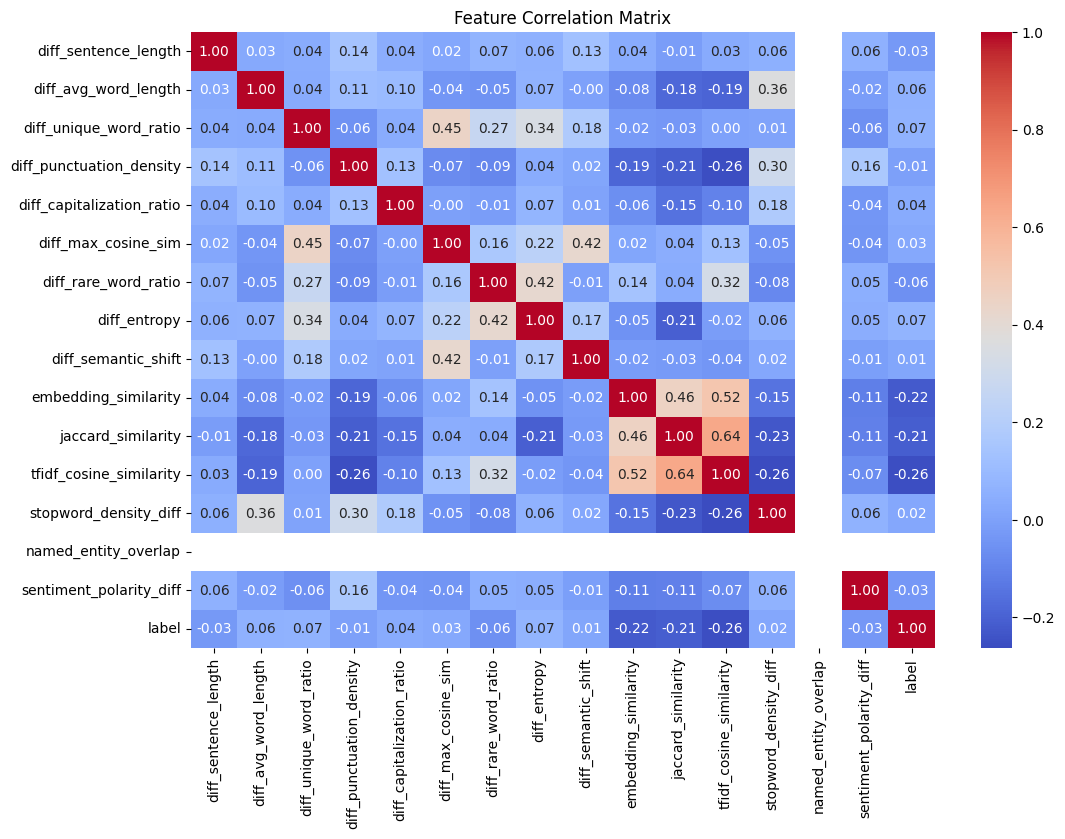

Correlation of features with the target variable (label):
 diff_sentence_length        -0.028879
diff_avg_word_length         0.058248
diff_unique_word_ratio       0.065378
diff_punctuation_density    -0.006493
diff_capitalization_ratio    0.035645
diff_max_cosine_sim          0.025075
diff_rare_word_ratio        -0.059538
diff_entropy                 0.070090
diff_semantic_shift          0.014148
embedding_similarity        -0.220740
jaccard_similarity          -0.210239
tfidf_cosine_similarity     -0.255186
stopword_density_diff        0.019716
named_entity_overlap              NaN
sentiment_polarity_diff     -0.031592
Name: label, dtype: float64


In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Assuming `consolidated_data` is the processed DataFrame
# Drop non-numeric columns (like paragraph texts and embeddings)
numeric_data = df_features_train.drop(columns=['paragraph_1', 'paragraph_2', 'embedding'], errors='ignore')

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Plot the heatmap for visualization
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

# Focus on the correlation with the target variable ('label')
label_correlation = correlation_matrix['label'].drop('label', errors='ignore')
print("Correlation of features with the target variable (label):\n", label_correlation)
